## Chargement des publication

Les publications de l'étape `1-Aggregation` peuvent être récupéré avec [ce lien dropbox (43 Mo)](https://www.dropbox.com/s/y1hf5ux8r5btmnn/publications.pk.bz2?dl=1
) 

In [1]:
import bibdb
import pickle, bz2

data = pickle.load(bz2.open('publications.pk.bz2', 'rb'))
publications = data['publications']
profs = data['profs']
authors = data['authors']
author_pubs = data['author_pubs']
del data

## Tokenization et lematization

La fonction `text_cleaning` implémente une tokenization et lematization du corpus a l'aide de la bibliothèque `nltk`. Une liste de stop-words anglais est utilisée, les nombres sont transformé en `[number]` et la ponctuation est retirée.

La lematization est réalisée avec wordnet et un POS tagger (Perceptron Tagger de nltk). Les deux premières lettres du tag sont rajoutées au lemme : "word/NN".

In [2]:
from text_cleaning import text_cleaning

lem_abstracts = []
lem_titles = []
for i, pub in enumerate(publications):
    if i & 1023 == 0:
        print('%.2f%%' % (100*i/len(publications)))
    
    lem_abstracts.append(text_cleaning(pub.en_abstract))
    
    en_titles = [ref.ref for ref in pub.refs if ref.reftype=='en_title']
    if en_titles:
        title = max(en_titles, key=len) # Longest english title
        lem_titles.append(text_cleaning(title))
    else:
        lem_titles.append([]) # keeps lists aligned

0.00%
1.70%
3.40%
5.10%
6.80%
8.50%
10.20%
11.90%
13.60%
15.30%
17.00%
18.69%
20.39%
22.09%
23.79%
25.49%
27.19%
28.89%
30.59%
32.29%
33.99%
35.69%
37.39%
39.09%
40.79%
42.49%
44.19%
45.89%
47.59%
49.29%
50.99%
52.68%
54.38%
56.08%
57.78%
59.48%
61.18%
62.88%
64.58%
66.28%
67.98%
69.68%
71.38%
73.08%
74.78%
76.48%
78.18%
79.88%
81.58%
83.28%
84.98%
86.67%
88.37%
90.07%
91.77%
93.47%
95.17%
96.87%
98.57%


Cette opération prend du temps (20min) et donc les résultats sont sauvegardés :

In [3]:
pickle.dump(dict(lem_abstracts=lem_abstracts,
                 lem_titles=lem_titles),
            bz2.open('lems.pk.bz2', 'wb'))

Le résultat de la lemmatisation est accesible [sur ce lien dropbox (27 Mo)](https://www.dropbox.com/s/pyu7n2tsztnu0js/lems.pk.bz2?dl=1)

In [4]:
import pickle, bz2
data = pickle.load(bz2.open('lems.pk.bz2', 'rb'))
lem_abstracts = data['lem_abstracts']
lem_titles = data['lem_titles']
del data

In [4]:
lem_abstract_withtitles = [lem_title + lem_abstract 
                           for lem_title, lem_abstract in zip(lem_titles, lem_abstracts)]

## Fréquence des mots, filtrage

Les lemmes taggés sont ensuite indexés avec `gensim.corpora.Dictionary`. Cet objet calcule également la fréquence document des mots.

In [5]:
from itertools import chain
import gensim

dictionary = gensim.corpora.Dictionary(lem_abstract_withtitles)

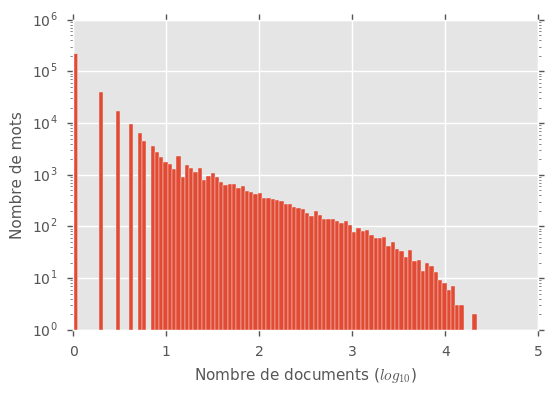

In [6]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

plt.hist([np.log10(count) for count in dictionary.dfs.values()],
         100, log=True)
plt.xlabel('Nombre de documents ($log_{10}$)')
plt.ylabel('Nombre de mots');

Les mot utilisés moins dans moins de 5 documents, ou dans plus de 1/4 des document sont retirés :

In [7]:
dictionary.filter_extremes(no_below=5, no_above=0.25, keep_n=None)

## Modèle `bag of words` par publication
Un modèle `bag of words` est construit en utilisant les indices numériques de `dictionary` (cela filtre aussi les mots).

In [8]:
bows = [dictionary.doc2bow(lems) for lems in lem_abstract_withtitles]

In [13]:
tfidfmodel = gensim.models.tfidfmodel.TfidfModel(bows, dictionary=dictionary)
tfidfs = tfidfmodel[bows]
lsimodel = gensim.models.lsimodel.LsiModel(tfidfs, id2word=dictionary)
lsimodel.save('lsimodel_bypub')

KeyboardInterrupt: 

In [18]:
for tid, words in lsimodel.show_topics(num_words=20):
    print(tid, '>>>', words)

0 >>> 0.303*"cancer/NN" + 0.220*"breast/NN" + 0.189*"mutation/NN" + 0.163*"patient/NN" + 0.161*"gene/NN" + 0.148*"risk/NN" + 0.132*"cell/NN" + 0.114*"tumor/NN" + 0.096*"expression/NN" + 0.091*"brca1/NN" + 0.089*"woman/NN" + 0.086*"family/NN" + 0.082*"p/NN" + 0.081*"genetic/JJ" + 0.078*"model/NN" + 0.078*"ovarian/JJ" + 0.076*"ci/NN" + 0.076*"variant/NN" + 0.075*"protein/NN" + 0.074*"associate/VB"
1 >>> -0.401*"cancer/NN" + -0.348*"breast/NN" + -0.211*"mutation/NN" + -0.186*"risk/NN" + -0.162*"brca1/NN" + -0.133*"woman/NN" + -0.122*"brca2/NN" + -0.115*"ovarian/JJ" + 0.106*"model/NN" + -0.105*"carrier/NN" + -0.098*"ci/NN" + 0.094*"system/NN" + 0.085*"method/NN" + 0.074*"network/NN" + 0.074*"structure/NN" + 0.070*"approach/NN" + 0.069*"protein/NN" + 0.069*"sequence/NN" + 0.069*"cell/NN" + -0.068*"family/NN"
2 >>> -0.326*"cell/NN" + -0.290*"gene/NN" + -0.215*"expression/NN" + -0.160*"mutation/NN" + -0.154*"protein/NN" + 0.141*"risk/NN" + -0.126*"tumor/NN" + 0.120*"patient/NN" + 0.116*"woman

In [ ]:
gensim.matutils.

In [14]:
lsimodel.save('lsimodel_bypub')

In [ ]:

plt.plot(lsimodel.projection.s);

In [13]:
hdpmodel = gensim.models.hdpmodel.HdpModel(bows, dictionary)
hdpmodel.save('hdpmodel_bypub.pk')

In [23]:
tc = lsimodel[bows]

In [27]:
gensim.matutils.corpus2dense(lsimodel[bows], lsimodel.num_topics).shape

(200, 36687)

In [29]:
gensim.matutils.corpus2csc(hdpmodel[bows]).shape

(150, 36687)

## Moyenne des modèles BoW par auteurs

## Modèles BoW par auteurs, abstract concaténées

In [11]:
len(authors), len(publications)

(64418, 60253)